<h1 style="color:orange; text-align:center;">Heart Failure Dataset</h1>

<span style='color:gray'>
Author: Vy Vu</br>
Created date: 10/05/2024
</span>

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, mutual_info_classif, SelectKBest, SequentialFeatureSelector
from pyswarm import pso
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<h2 style="color:purple; text-align:left;">ETL and EDA</h2>

In [2]:
# Load the data
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
data['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

The dataset consists of 918 observations with 12 features, including 1 target feature named `HeartDisease`. Since `HeartDisease` is a categorical variable where 0 indicates "normal" and 1 indicates "heart disease", this problem falls under classification. Below is the detail of attribution information.</br>
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]
</br>

Considering the attribution information above, our features contain both numeric and categorical variables.
* Numeric variables are `Age`, `RestingBP`, `Cholesterol`, `MaxHR`, `Oldpeak`
* Categorical variables are `Sex`, `ChestPainType`, `FastingBS`, `RestingECG`, `ExerciseAngina`, `ST_Slope`
</br>

Next, we will check whether or not the dataset includes any missing values.

In [5]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset does not include any missing values. Now, we will examining basic statistics and distributions of each feature.

In [6]:
all_vars = data.columns
numeric_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [7]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Age

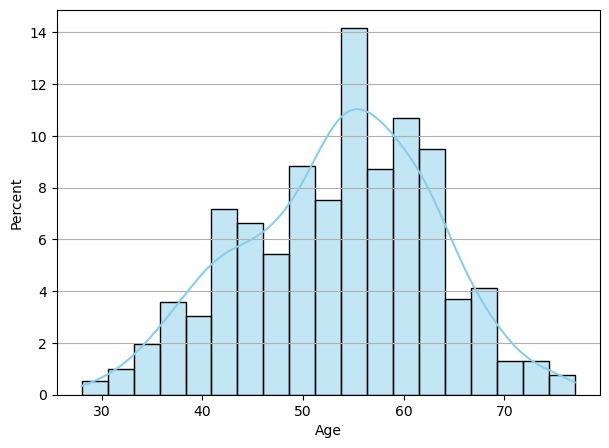

In [8]:
plt.figure(figsize=(7, 5))
sns.histplot(data['Age'], kde=True, color='skyblue', stat='percent')
plt.grid(axis='y')
plt.show()

Based on the basic statistics above and the histogram, the youngest age in this dataset is 28 and the oldest age is 77. Both the mean and the median age in this dataset are 54. The feature 'Age' in this dataset follows a left-skewed distribution. The majority of observations appear to belong to the age range between 50 and 60.

#### Sex

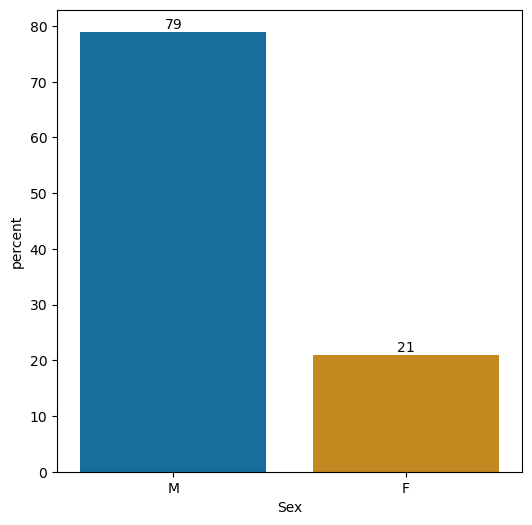

In [9]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data, x='Sex', hue='Sex', palette='colorblind', stat='percent')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 5),
                textcoords = 'offset points')
    
plt.show()

In this dataset, the majority of the observations are male, accounting for up to 79%. In other words, the male proportion is around 3.8 times higher than the female proportion.

#### ChestPainType

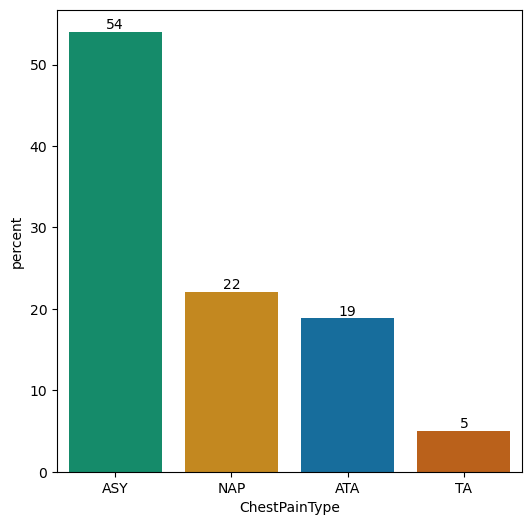

In [10]:
value_counts = data['ChestPainType'].value_counts()
desired_order = value_counts.sort_values(ascending=False)

plt.figure(figsize=(6,6))
ax = sns.countplot(data, x='ChestPainType', hue='ChestPainType', palette='colorblind', stat='percent', order=desired_order.index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 5),
                textcoords = 'offset points')
    
plt.show()

There are four distinct chest pain types in this dataset.</br>
1. TA: Typical Angina - This type of chest pain is described as a discomfort or pressure in the chest that typically occurs with exertion or stress. It's caused by reduced blood flow to the heart.
2. ATA: Atypical Angina - This type of chest pain differs from typical angina in its presentation or characteristics. It may still involve discomfort or pressure in the chest but might not follow the classic pattern associated with typical angina.
3. NAP: Non-Anginal Pain - This refers to chest pain that is not related to reduced blood flow to the heart. It could be caused by other factors such as musculoskeletal issues, gastrointestinal problems, or anxiety.
3. ASY: Asymptomatic - This indicates the absence of any chest pain or discomfort. It means the individual does not experience any symptoms related to chest pain.
</br>
</br>

In this dataset, ASY (Asymptomatic) accounts for 54% of the observations, following by NAP (Non-Anginal) at 22%, then ATA (Atypical Angina) at 19%, and lastly TA (Typical Angina) at 5%. While the proportion of ASY is remarkably high, the proportion of TA is significantly low. NAP and ATA are not much difference.


In this dataset, ASY (indicating Asymptomatic) accounts for 54% of the observations, followed by NAP (Non-Anginal Pain) at 22%, then ATA (Atypical Angina) at 19%, and lastly TA (Typical Angina) at 5%. While the proportion of ASY is remarkably high, the proportion of TA is significantly low. NAP and ATA are not different.

#### RestingBP

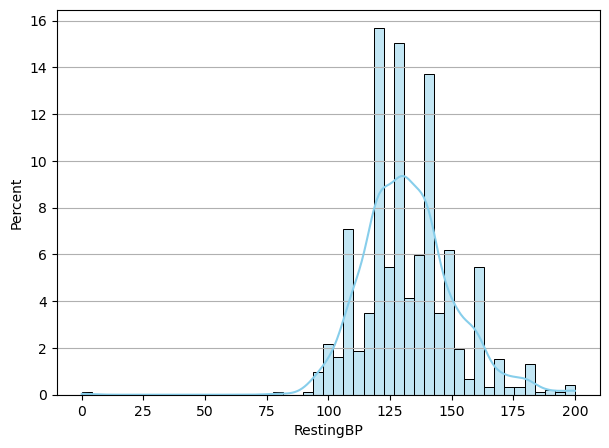

In [11]:
plt.figure(figsize=(7, 5))
sns.histplot(data, x='RestingBP', kde=True, stat='percent', color='skyblue')
plt.grid(axis='y')
plt.show()

In [12]:
print(f"The number of observation with RestingBP is equal to 0: {len(data[data['RestingBP']==0])}")

The number of observation with RestingBP is equal to 0: 1


`RestingBP` indicates resting blood pressure (mm Hg). Resting blood pressure is dependent on the gender and age. However, as a general guide, ideal blood pressure is considered to be between 90/60mm Hg and 120/80mm Hg. High blood pressure is considered to be 140/90mmHg or higher, while low blood pressure is considered to be below 90/60mmHg. In the histogram above, one observation has 0 mm Hg for resting blood pressure. This is physiologically impossible because blood pressure is the force of blood pushing against the walls of the arteries as the heart pumps blood. Hence, resting blood pressure values of exactly 0 mm Hg are not possible in a living human being. Therefore, the observation with a resting blood pressure of 0 is likely a typo. Additionally, in the dataset, the majority of resting blood pressure values range from 115 mm Hg to 130 mm Hg. Excluding the zero value, the histogram of `RestingBP` nearly follows a Gaussian distribution.

#### Cholesterol

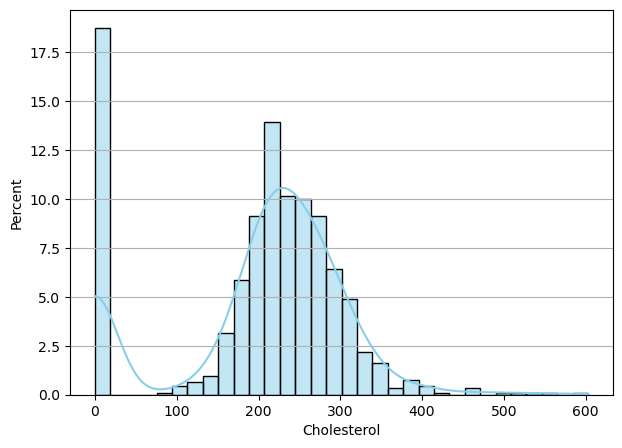

In [13]:
plt.figure(figsize=(7, 5))
sns.histplot(data, x='Cholesterol', kde=True, stat='percent', color='skyblue')
plt.grid(axis='y')
plt.show()

In [14]:
len(data[data['Cholesterol']==0])

172

In the histogram above, we have 172 observations, accounting for over 17.5% of the entire dataset. Similar to `RestingBP`, cholesterol values of exactly 0 are highly unlikely and not physiologically possible in a living human being. Hence, these records can be a typo or a missing value defaulting to 0 or both.</br>
Excluding all the observations with the cholesterol value of 0, the distribution of `Cholesterol` appears a Gaussian distribution, where over 200 mm/dl dominanting. In addition, the maximum value of `Cholesterol` in this dataset is 603 mm/dl which would generally be considered very high and may indicate hypercholesterolemia, a condition characterized by elevated levels of cholesterol in the blood.</br>
Overall, healthy cholesterol levels can vary based on individual factors such as age, sex, overall health, and any existing medical conditions or risk factors for cardiovascular disease. According to Johns Hopkins Medicine, total cholesterol levels for adults are categorized as:
* Normal: Less than 200 mg/dL
* Borderline-high: 200 to 239 mg/dL
* High: At or above 240 mg/dL

#### FastingBS

FastingBS refers to fasting blood sugar, assigned a value of 1 if FastingBS is greater than 120 mg/dl and 0 otherwise. Although it is represented numerically, FastingBS is considered a categorical variable.

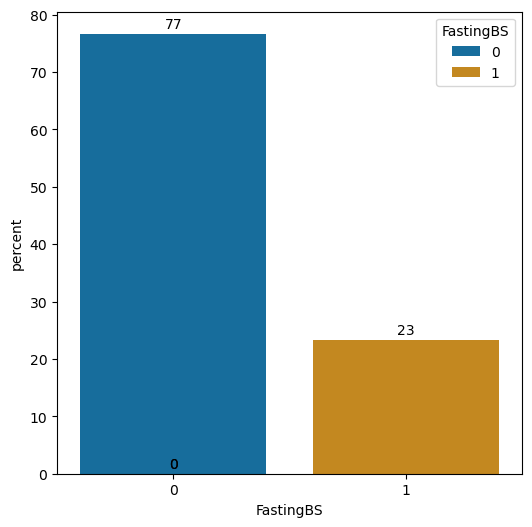

In [15]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data, x='FastingBS', hue='FastingBS', palette='colorblind', stat='percent')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 7),
                textcoords = 'offset points')
    
plt.show()

In this dataset, 77% of observations have fasting blood sugar levels equal to or less than 120 mg/dL, while 23% have levels greater than 120 mg/dL. According to Mayoclinic.org, a fasting blood sugar level less than 100 mg/dL (5.6 mmol/L) is considered normal. A level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is classified as prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, the person is diagnosed with diabetes.

#### RestingECG

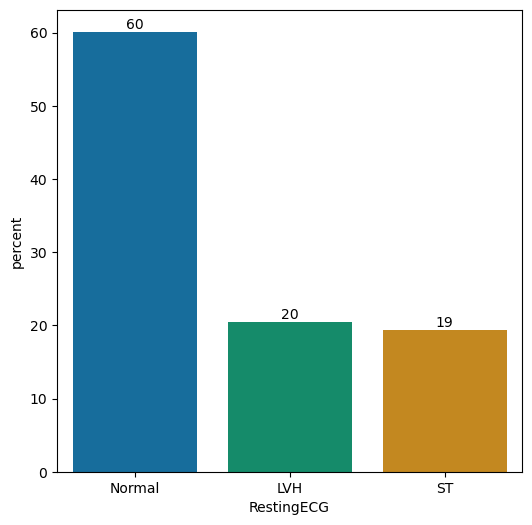

In [16]:
value_counts = data['RestingECG'].value_counts()
desired_order = value_counts.sort_values(ascending=False)

plt.figure(figsize=(6,6))
ax = sns.countplot(data, x='RestingECG', hue='RestingECG', palette='colorblind', stat='percent', order=desired_order.index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 5),
                textcoords = 'offset points')
    
plt.show()

`RestingECG` refers to resting electrocardiogram results. In this context, 'Normal' indicates a normal result, 'ST' signifies the presence of ST-T wave abnormalities (such as T wave inversions and/or ST elevation or depression of > 0.05 mV), and 'LVH' indicates probable or definite left ventricular hypertrophy according to Estes' criteria. The dataset reveals that 60% of the observations show normal results, 20% exhibit LVH, and 19% display ST abnormalities.

#### MaxHR

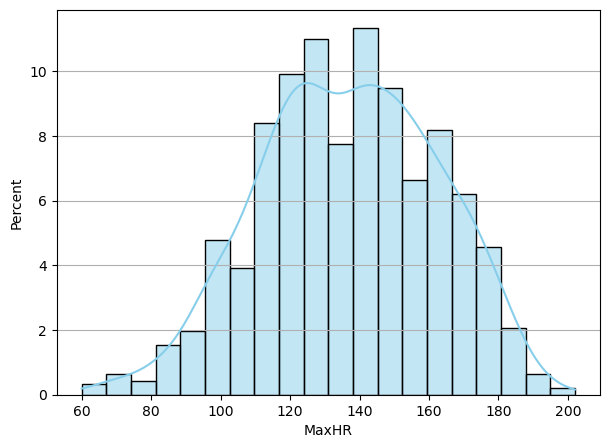

In [17]:
plt.figure(figsize=(7, 5))
sns.histplot(data, x='MaxHR', kde=True, stat='percent', color='skyblue')
plt.grid(axis='y')
plt.show()

As mentioned above, `MaxHR` indicates maximum heart rate achieved. Its data type is numeric where its value lies between 60 and 202. The distribution of `MaxHR` is slightly negatively skewed. The majority of maximum heart rate values are at approximately 120 and 145.

#### ExerciseAngina

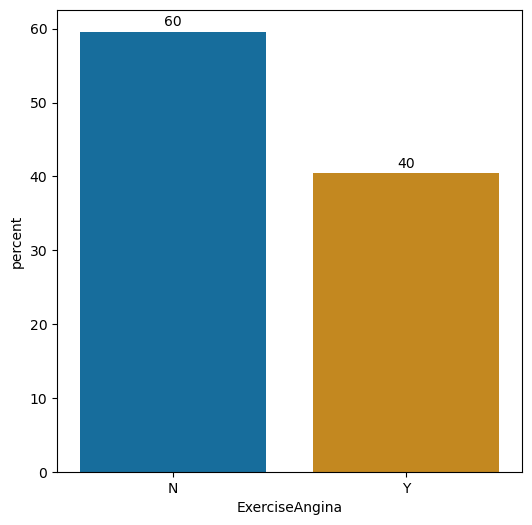

In [18]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data, x='ExerciseAngina', hue='ExerciseAngina', palette='colorblind', stat='percent')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 7),
                textcoords = 'offset points')
    
plt.show()

`ExerciseAngina` indicates exercise-induced angina. This variable is boolean, with options for 'Yes' or 'No'. According to the count plot, 60% of the observations do not exhibit exercise-induced angina, while 40% experience it during exercise.

#### Oldpeak

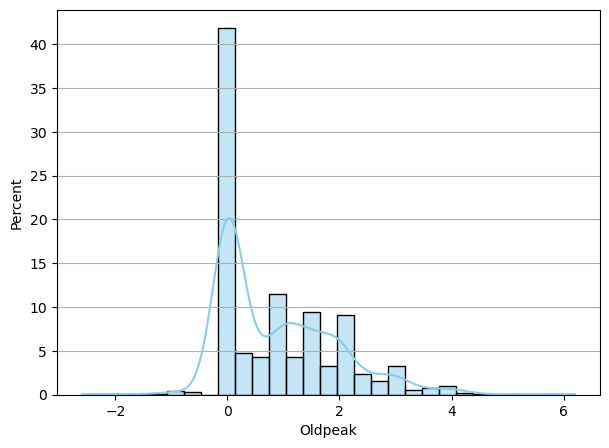

In [19]:
plt.figure(figsize=(7, 5))
sns.histplot(data, x='Oldpeak', kde=True, stat='percent', color='skyblue')
plt.grid(axis='y')
plt.show()

Based on the basic statistics above and the histogram, `Oldpeak` has a minimum value of -2.6 and a maximum value of 6.2. The majority of the observations are at 0, accounting for over 40% of the entire dataset. Other values account for 11% or less.

#### ST_Slope

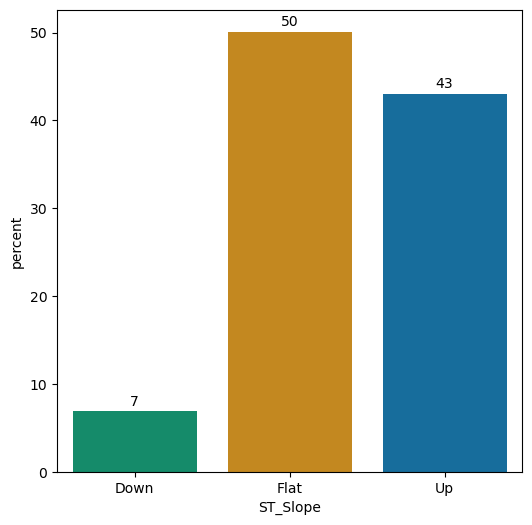

In [20]:
plt.figure(figsize=(6,6))
desired_order = ['Down', 'Flat', 'Up']
ax = sns.countplot(data, x='ST_Slope', hue='ST_Slope', palette='colorblind', stat='percent', order=desired_order)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha = 'center', va = 'center',
                xytext=(0, 7),
                textcoords = 'offset points')
    
plt.show()

`ST_Slope` indicates the slope of the peak exercise ST segment, where "Up" signifies upsloping, "Flat" denotes a flat slope, and "Down" indicates downsloping. In this dataset, the majority of observations exhibit a flat slope in the peak exercise ST segment, accounting for 50% of the entire dataset. The next most common slope, accounting for 43%, is upsloping. Lastly, only 7% of observations show a downsloping slope.

We can explore the features further by creating a correlation matrix between two features in the dataset.

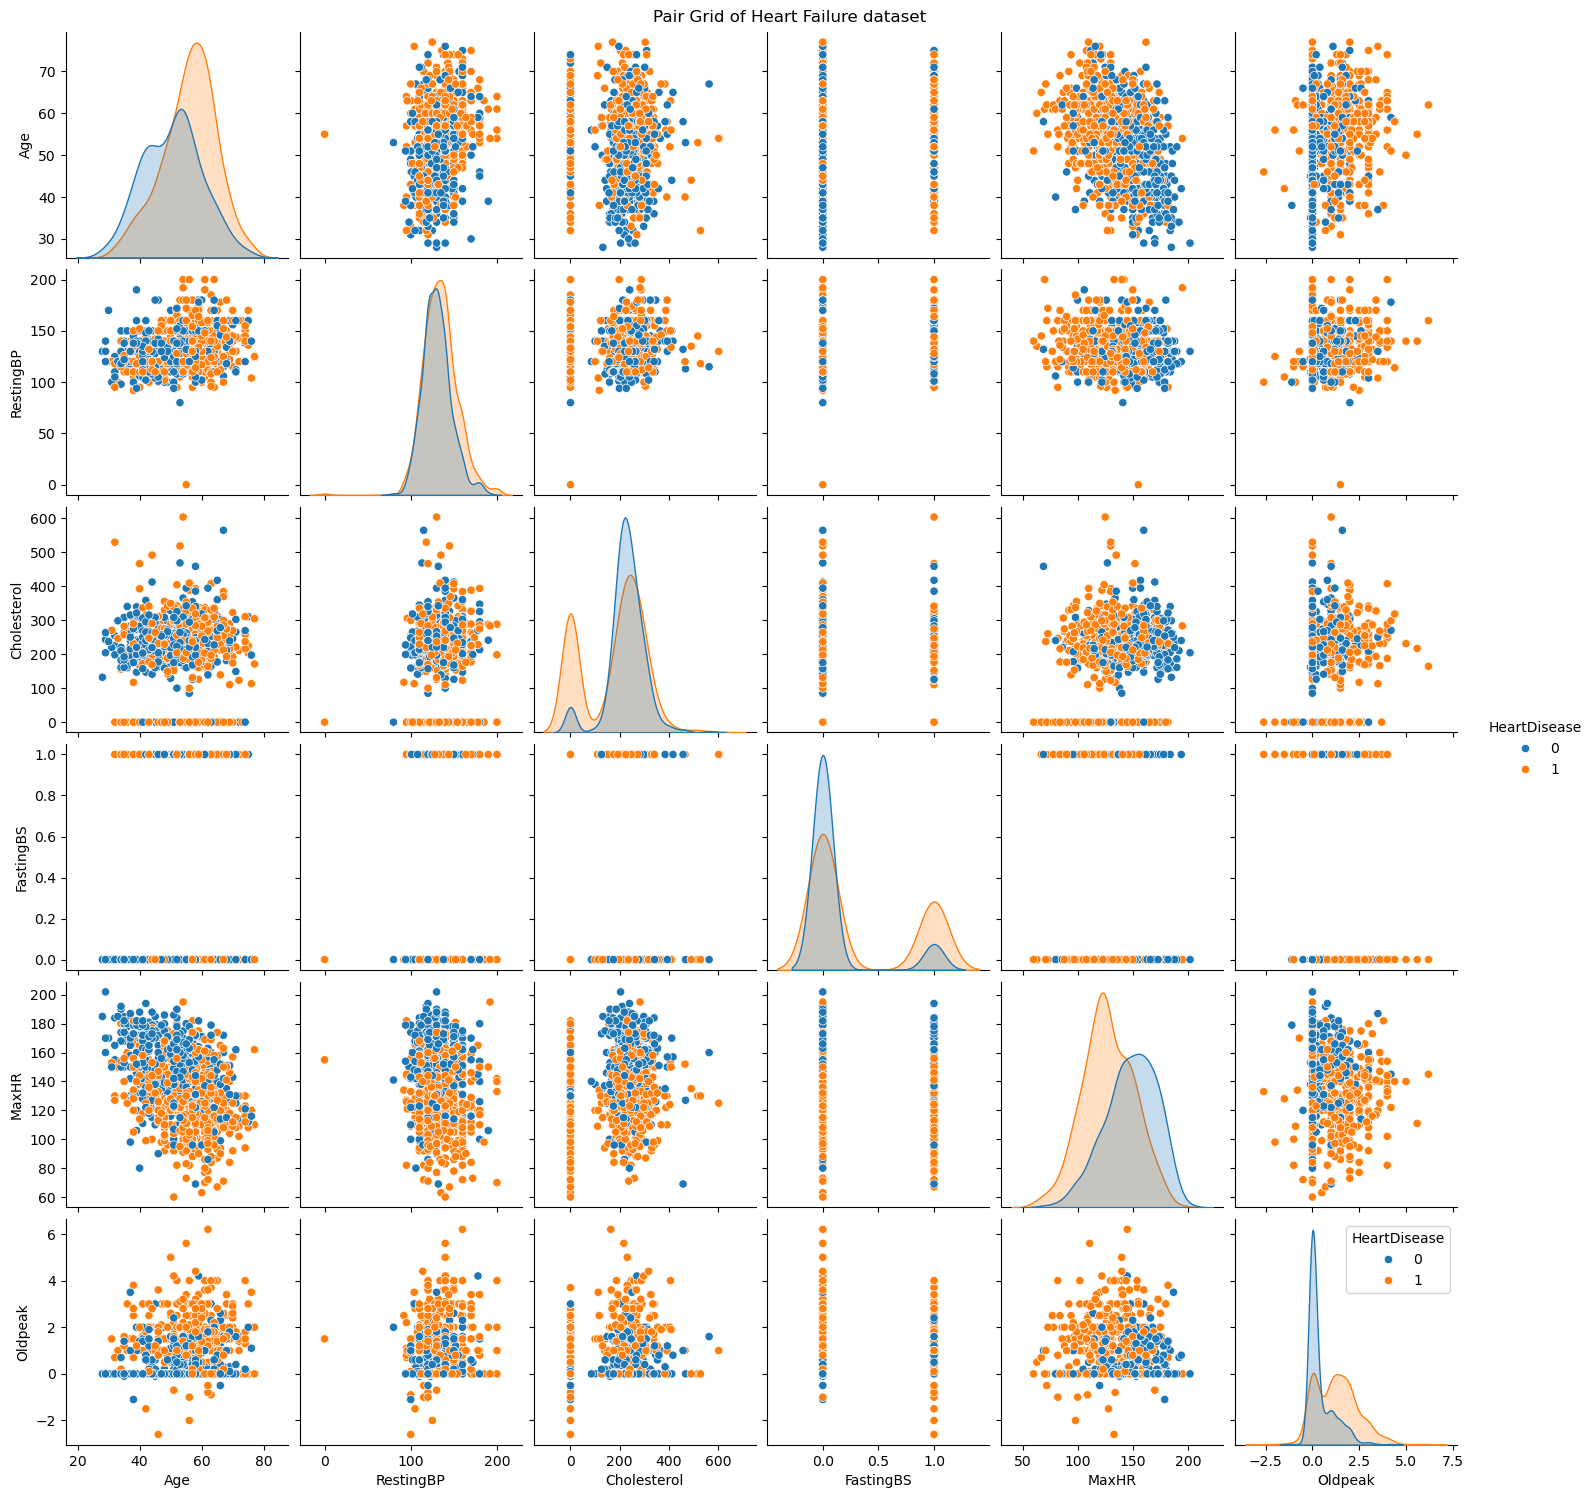

In [21]:
g= sns.pairplot(data, hue='HeartDisease')
plt.suptitle('Pair Grid of Heart Failure dataset', y=1)
handles = g._legend_data.values()
labels = g._legend_data.keys()
plt.legend(handles, labels, title='HeartDisease', loc='upper right')
plt.show();

In the pair grid above, there are no clearly particular correlations between any features. However, there are still some highlights:
1. Observations having heart disease appear to have lower `MaxHR`, compared to observations without heart disease.
3. The data points with or without heart disease show no specific patterns in `RestingBP`, `Cholesterol`, `FastingBP`, `MaxHR`, and `Oldpeak`, regardless of age.</br>

Some research studies often mention that resting blood pressure, fasting blood sugar, cholesterol, and old peak levels depend on factors such as gender and age. Therefore, next, we will examine the relationship between gender, age, or both, and other features. We can start by exploring the relationship between `Age` and `ChestPainType`.

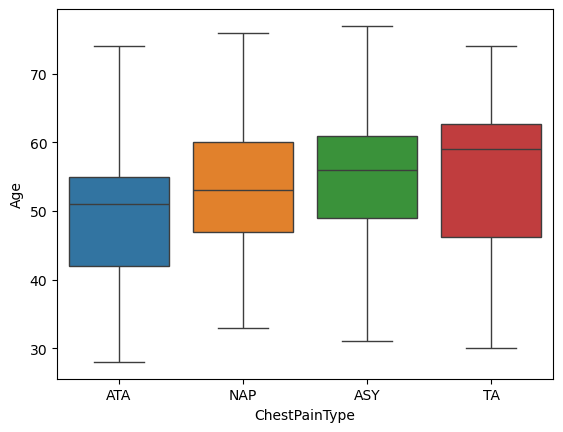

In [22]:
sns.boxplot(data=data, x='ChestPainType', hue='ChestPainType', y='Age')
plt.show()

Based on the box plot above, observations indicate that individuals experience chest pain regardless of age. However, there are notable differences among different types of chest pain. For instance, the gap between the 2nd and 3rd quartiles of typical angina (TA) is larger than for other chest pain types, and the median value for TA is also higher. Additionally, the youngest individual experiencing atypical angina (ATA) is under 30, while the youngest individual with non-anginal pain (NAP) is nearly 35. The oldest individual in the dataset is asymptomatic.</br>
Next, we will explore the relationship between `RestingBP` and `Cholesterol` by `Sex`.

In [23]:
male_data = data[data['Sex']=='M']
female_data = data[data['Sex']=='F']

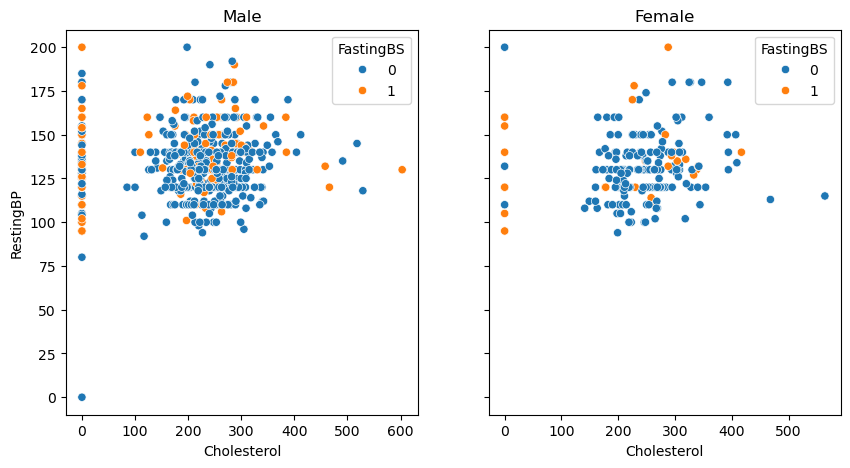

In [24]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2, sharey=True)

sns.scatterplot(data=male_data, x='Cholesterol', y='RestingBP', hue='FastingBS', ax=axes[0])
axes[0].set_title("Male")

sns.scatterplot(data=female_data, x='Cholesterol', y='RestingBP', hue='FastingBS', ax=axes[1])
axes[1].set_title("Female")

plt.show()

After analyzing the two scatter plots, it seems that there are no discernible relationships between `Cholesterol` and `RestingBP` based on `Sex` and `FastingBS`. In other words, regardless of whether individuals experience fasting blood sugar and irrespective of gender, predicting resting blood pressure solely based on cholesterol levels appears to be challenging. Furthermore, considering the relatively low proportion of female observations compared to males in this dataset, we may not have a sufficient number of data points to reliably identify any patterns in this context.

In [25]:
ye_data = data[data['ExerciseAngina']=='Y']
ne_data = data[data['ExerciseAngina']=='N']

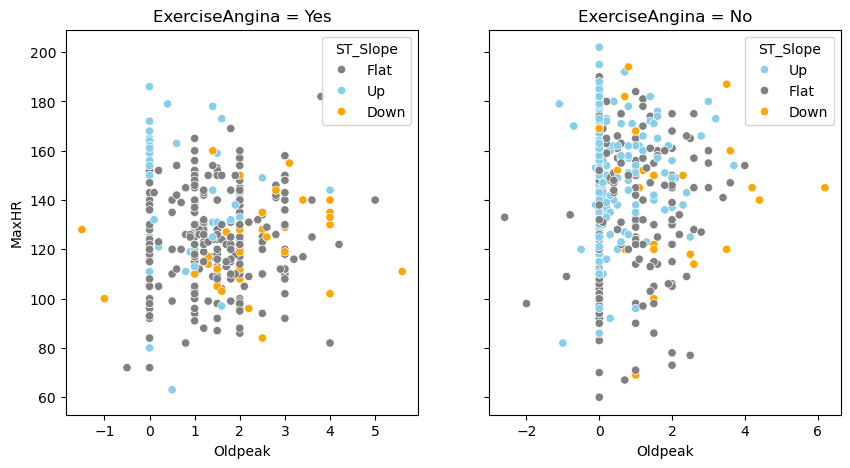

In [26]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2, sharey=True)

custom_palette = {'Flat': 'grey', 'Up': 'skyblue', 'Down': 'orange'}
legend_order = ['down', 'flat', 'up']

sns.scatterplot(data=ye_data, x='Oldpeak', y='MaxHR', hue='ST_Slope', ax=axes[0], palette=custom_palette)
axes[0].set_title("ExerciseAngina = Yes")

sns.scatterplot(data=ne_data, x='Oldpeak', y='MaxHR', hue='ST_Slope', ax=axes[1], palette=custom_palette)
axes[1].set_title("ExerciseAngina = No")

plt.show()

Comparing the presence and absence of exercise-induced angina reveals that in the left scatter plot, where exercise angina is present ('Yes'), a greater number of observations with a flat slope of the peak exercise ST segment are represented in gray. Similarly, in the scatter plot corresponding to individuals without exercise-induced angina ('No'), a higher proportion exhibits an upsloping trend, with the old peak ranging from 0 to 4. However, the impact of exercise-induced angina on downsloping, maximum heart rate, and old peak cannot be definitively determined, as the downsloping pattern accounts for only 7% of the entire dataset.

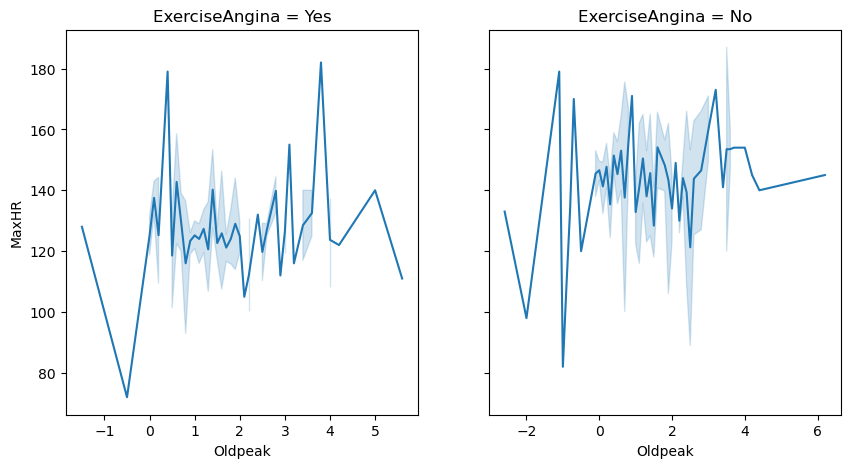

In [27]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2, sharey=True)

sns.lineplot(data=ye_data, x='Oldpeak', y='MaxHR', ax=axes[0])
axes[0].set_title("ExerciseAngina = Yes")

sns.lineplot(data=ne_data, x='Oldpeak', y='MaxHR', ax=axes[1])
axes[1].set_title("ExerciseAngina = No")

plt.show()

Regardless of the presence of exercise-induced angina, the old peak consistently ranges from -2 to 6, and the maximum heart rate remains between 70 and 180. However, among individuals experiencing exercise-induced angina, the majority achieve a maximum heart rate ranging from 120 to 140. In contrast, for those without exercise-induced angina, the maximum heart rate achieved falls between 138 and 158. Furthermore, observations with exercise-induced angina exhibit significant fluctuations in maximum heart rate when the old peak reaches extreme values (less than 1 or greater than 4). Conversely, records without exercise-induced angina only display fluctuations in maximum heart rate when the old peak is less than 0.

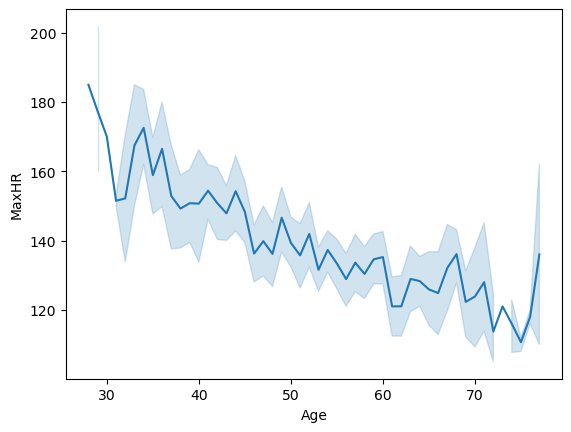

In [28]:
sns.lineplot(data=data, x='Age', y='MaxHR')
plt.show()

The line plot presents an intriguing trend. It illustrates a negative relationship between age and the maximum heart rate achieved. In the early 30s, individuals reach maximum heart rates as high as 185 beats per minute, but as they age, this figure decreases. By the time individuals reach their 70s, the maximum heart rate tends to stabilize around 120 beats per minute. However, there are exceptions to this pattern. Overall, the relationship between `Age` and maximum heart rate (`MaxHR`) is predominantly negative.

In [29]:
ta_data = data[data['ChestPainType']=='TA']
ata_data = data[data['ChestPainType']=='ATA']
nap_data = data[data['ChestPainType']=='NAP']
asy_data = data[data['ChestPainType']=='ASY']

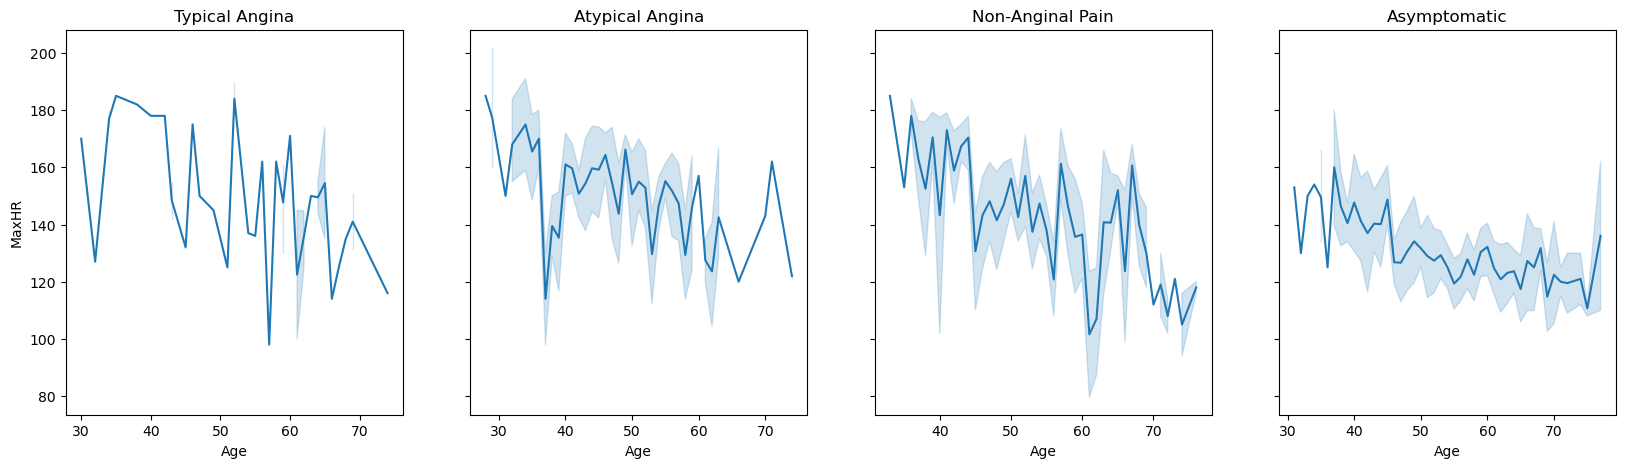

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

sns.lineplot(data=ta_data, x='Age', y='MaxHR', ax=axes[0])
axes[0].set_title("Typical Angina")

sns.lineplot(data=ata_data, x='Age', y='MaxHR', ax=axes[1])
axes[1].set_title("Atypical Angina")

sns.lineplot(data=nap_data, x='Age', y='MaxHR', ax=axes[2])
axes[2].set_title("Non-Anginal Pain")

sns.lineplot(data=asy_data, x='Age', y='MaxHR', ax=axes[3])
axes[3].set_title("Asymptomatic")

plt.show()

In the four line plots above, individuals with typical angina exhibit the most fluctuated maximum heart rate across different age groups. Conversely, asymptomatic observations demonstrate a notably stable maximum heart rate, albeit showing a slight downward trend with increasing age. Non-anginal pain records depict a significant drop in maximum heart rate around the age of 60, while observations of atypical angina show a pronounced decrease close to 40 years old. These findings suggest that typical angina may have a discernible impact on the maximum heart rate achieved.</br>
Next, we will generate scatter plots using the same parameters to investigate if any additional patterns emerge.

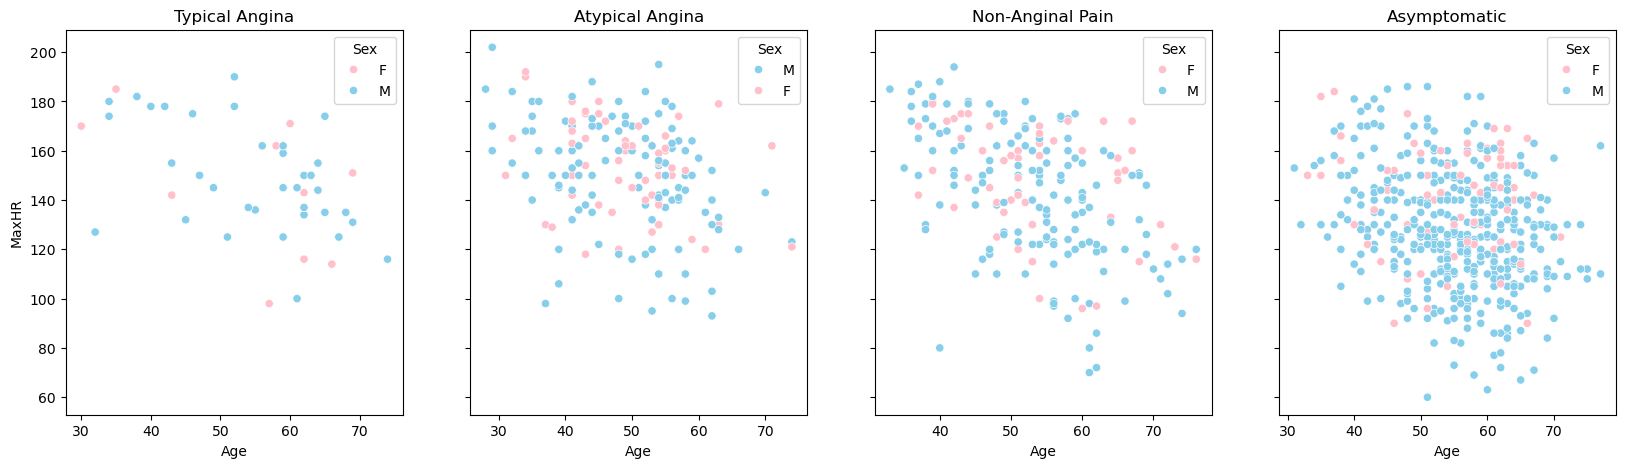

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

custom_palette = {'M': 'skyblue', 'F': 'pink'}

sns.scatterplot(data=ta_data, x='Age', y='MaxHR', hue='Sex', ax=axes[0], palette=custom_palette)
axes[0].set_title("Typical Angina")

sns.scatterplot(data=ata_data, x='Age', y='MaxHR', hue='Sex', ax=axes[1], palette=custom_palette)
axes[1].set_title("Atypical Angina")

sns.scatterplot(data=nap_data, x='Age', y='MaxHR', hue='Sex', ax=axes[2], palette=custom_palette)
axes[2].set_title("Non-Anginal Pain")

sns.scatterplot(data=asy_data, x='Age', y='MaxHR', hue='Sex', ax=axes[3], palette=custom_palette)
axes[3].set_title("Asymptomatic")

plt.show()

The dataset predominantly comprises asymptomatic cases, with only a few instances of typical angina. Additionally, there are no discernible differences in gender distribution across different chest pain types.

In [32]:
normal_data = data[data['RestingECG']=='Normal']
st_data = data[data['RestingECG']=='ST']
lvh_data = data[data['RestingECG']=='LVH']

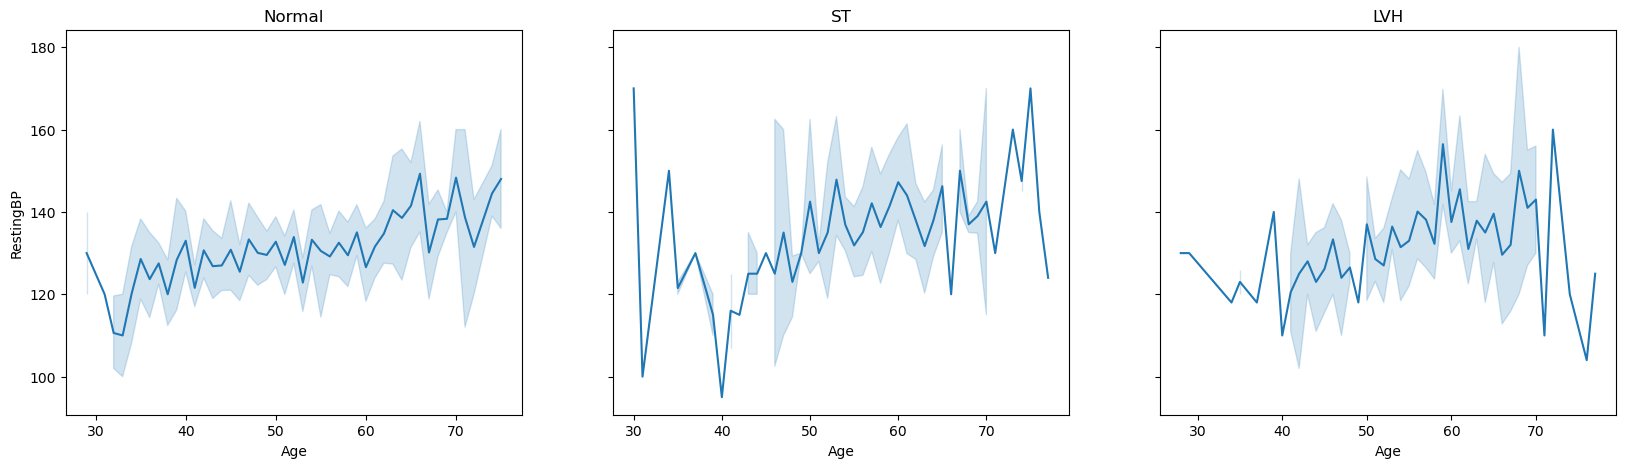

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.lineplot(data=normal_data, x='Age', y='RestingBP', ax=axes[0])
axes[0].set_title("Normal")

sns.lineplot(data=st_data, x='Age', y='RestingBP', ax=axes[1])
axes[1].set_title("ST")

sns.lineplot(data=lvh_data, x='Age', y='RestingBP', ax=axes[2])
axes[2].set_title("LVH")

plt.show()

For individuals with a normal resting ECG, resting blood pressure appears to stabilize with increasing age. However, observations with ST abnormalities and LVH exhibit fluctuating resting blood pressure levels across different age groups. For instance, individuals with ST abnormalities who are younger than 40 years old may experience significant fluctuations in resting blood pressure. Similarly, records showing LVH in individuals over 70 years old also demonstrate substantial variability in resting blood pressure, particularly as age surpasses 70. Between the ages of 40 and 70, the resting blood pressure tends to be more stable across different resting ECG readings.

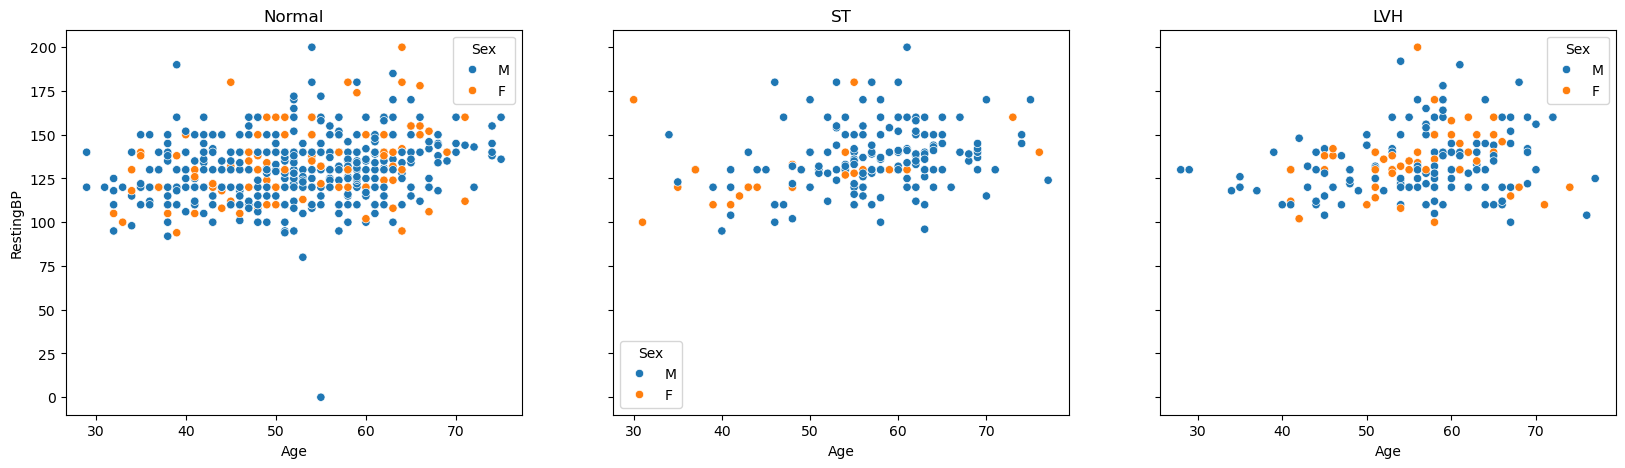

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

sns.scatterplot(data=normal_data, x='Age', y='RestingBP', hue='Sex', ax=axes[0])
axes[0].set_title("Normal")

sns.scatterplot(data=st_data, x='Age', y='RestingBP', hue='Sex', ax=axes[1])
axes[1].set_title("ST")

sns.scatterplot(data=lvh_data, x='Age', y='RestingBP', hue='Sex', ax=axes[2])
axes[2].set_title("LVH")

plt.show()

Similar to `ChestPainType`, the distribution of data points across categories in `RestingECG` is uneven. The majority of observations fall under the "Normal" category, whereas "ST" and "LVH" have fewer data points. Overall, there appears to be an imbalance in the distribution among categories in each feature such as `Sex`, `ChestPainType`, `RestingECG`, and `ST_Slope`.

<h2 style="color:purple; text-align:left;">Feature Engineering</h2>

<h3 style="color:orange; text-align:left;">Feature Encoding</h3>

Now, we will convert categorical features to ordinal or one-hot encoding. As we all know, the choice between one-hot encoding and ordinal encoding can significantly impact the performance of supervised learning algorithms. Hence, we would like to briefly discuss the supervised learning algorithms that we will use in this project. The three algorithms we will implement are Support Vector Machines (SVMs), Gradient Boosting, and Neural Networks.</br>
</br>
With SVMs, both ordinal encoding and one-hot encoding can work well. Since SVMs rely on computing distances between data points in feature space, the choice between the two encoding methods may not significantly impact performance. However, if there is an inherent order in the categories (e.g., "low," "medium," "high"), ordinal encoding might preserve that information and potentially improve SVM performance. Similarly, Gradient Boosting algorithms are generally agnostic to the type of encoding used; they can handle both ordinal and one-hot encoding effectively. Gradient Boosting builds decision trees sequentially, and the choice of encoding typically does not significantly affect the algorithm's performance.</br>
</br>
In contrast, the choice between ordinal encoding and one-hot encoding is indeed important when using Neural Networks. Neural networks can learn complex relationships, but they rely heavily on the quality of the input data. The wrong encoding can hinder the network's ability to capture relevant patterns.</br>
</br>
Since this dataset does not have features with an inherent order, we will convert `Sex` and `ExerciseAngina` to numeric encoding, and other categorical features to one-hot encoding.

In [35]:
data['Sex_Encoded'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina_Encoded'] = data['ExerciseAngina'].map({'N': 0, 'Y': 1})
temp = data[['ChestPainType', 'RestingECG', 'ST_Slope']]
temp = pd.get_dummies(temp, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], dtype='int', drop_first=True)
df = pd.concat([data, temp], axis=1)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,HeartDisease,Sex_Encoded,ExerciseAngina_Encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,M,ATA,140,289,0,Normal,172,N,0.0,...,0,1,0,1,0,0,1,0,0,1
1,49,F,NAP,160,180,0,Normal,156,N,1.0,...,1,0,0,0,1,0,1,0,1,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,...,0,1,0,1,0,0,0,1,0,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,...,1,0,1,0,0,0,1,0,1,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,...,0,1,0,0,1,0,1,0,0,1


<h3 style="color:orange; text-align:left;">Feature - Checking Balance</h3>

In [36]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

Checking the balance of independent features helps us understand the distribution of data within each feature. Imbalanced features can affect the performance of certain machine learning algorithms or lead to biased models. It's worth noting that imbalanced features can cause issues such as the dominance of certain features over others, leading to skewed model predictions, or difficulty for algorithms to learn from imbalanced data, especially for algorithms sensitive to feature distributions, like distance-based methods. In our project, imbalanced independent features can pose a potential issue for SVMs.</br>
</br>
In our exploratory data analysis (EDA), we have identified that some categorical variables are not evenly distributed. These include `Sex`, `ST_Slope`, `RestingECG`, `FastingBS`, and `ChestPainType`. However, the target feature `HeartDisease` is fairly evenly distributed, so unbalanced dataset is not a main concern for now.

In [37]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease', 'Sex_Encoded', 'ExerciseAngina_Encoded',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

Now, we will separate the features (X) and the target variable (y) in preparation for the next step, which involves standardization.

In [38]:
X = df[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_Encoded', 'ExerciseAngina_Encoded', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']]
y = df['HeartDisease']

In [39]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_Encoded,ExerciseAngina_Encoded,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,1,0,1,0,0,1,0,0,1
1,49,160,180,0,156,1.0,0,0,0,1,0,1,0,1,0
2,37,130,283,0,98,0.0,1,0,1,0,0,0,1,0,1
3,48,138,214,0,108,1.5,0,1,0,0,0,1,0,1,0
4,54,150,195,0,122,0.0,1,0,0,1,0,1,0,0,1


In [40]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

<h3 style="color:orange; text-align:left;">Feature Standardization</h3>

Since SVMs and Neural Networks will be used as two of the three supervised learning algorithms, we will need to either standardize or normalize the dataset. The choice between standardization and normalization depends on the specific characteristics of the data and the requirements of the machine learning algorithm. Overall, standardization may be a better fit for all the algorithms, especially given that the Heart Failure dataset includes features with different units or scales. Standardization helps to center the data and ensures that each feature contributes equally to the model. However, it’s important to note that the underlying assumption of standardization is a Gaussian distribution. If the linear SVM does not yield satisfactory results, we can consider using normalization later.

In [41]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

<h2 style="color:purple; text-align:left;">Predictive Models: Support Vector Machines</h2>

As we mentioned above, in this project, we will use SVM, Gradient Boosting, and Neural Network to build the model.

<h3 style="color:orange; align-text:left">Support Vector Machines (SVMs) - Full Model</h3>

Support Vector Machines (SVMs) are a form of supervised machine learning algorithm predominantly used for classification, although they can also be used for regression. The fundamental principle of SVM is to identify a hyperplane that optimally segregates the data into distinct classes. This hyperplane manifests as a line in a 2-dimensional space and as a plane or hyperplane in higher dimensions.</br>
</br>
Here’s a breakdown of its operation:
* Margin Maximization: SVMs aim to not only discover a hyperplane that partitions the data but also to maximize the margin between the classes. The margin is the distance from the separating hyperplane (or decision boundary) to the closest data point from either class. The data points that lie on the margins are termed ‘support vectors’.
* Classification: After the hyperplane is determined, new data points are classified depending on which side of the hyperplane they reside on.

First, we will use the most simple SVM which is linear SVMs. To prevent the data leakage, we will use pipeline in sklearn. The purpose of a pipeline in scikit-learn is to assemble several steps that can be cross-validated together while setting different parameters. For the metric performance, we will use accuracy score. Beside, we will use 10-fold cross validation.

<h5 style="color:green; align-text:left">Linear SVMs</h5>

In [42]:
param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
pipe = Pipeline(steps=[('svc', svm.SVC(kernel='linear', random_state=71))])
kf = KFold(n_splits=10)
linear_grid_search = GridSearchCV(pipe, param_grid, cv=kf, scoring='accuracy')
linear_grid_search.fit(scaled_X, y)

print(f"The best C is {linear_grid_search.best_params_} and its test mean score is {max(linear_grid_search.cv_results_['mean_test_score'])}")

The best C is {'svc__C': 0.1} and its test mean score is 0.8528069756330625


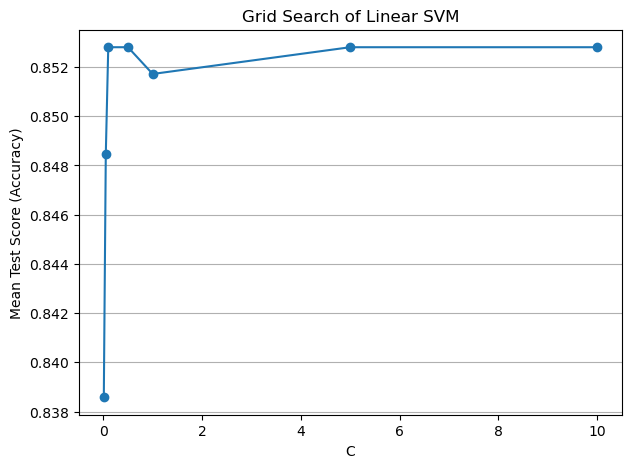

In [43]:
scores_mean = linear_grid_search.cv_results_['mean_test_score']
param_c = param_grid['svc__C']

plt.figure(figsize=(7, 5))
plt.plot(param_c, scores_mean, '-o')
plt.xlabel('C')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Grid Search of Linear SVM')
plt.grid(axis='y')
plt.show()

The optimal linear SVM model was found with a C parameter of 0.1, yielding a mean test score of 0.85. We now turn our attention to the kernel SVM to investigate if it can outperform the linear SVM. Just like the linear SVM, we will construct the kernel SVM model using a pipeline and evaluate its performance using 10-fold cross-validation. However, the kernel SVM is inherently more complex than its linear counterpart due to the additional parameters we need to consider, such as C, and gamma.

<h5 style="color:green; text-align:left">SVM using Radial Basis Function (RBF) kernel</h5>

In [44]:
param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'svc__gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
pipe = Pipeline(steps=[('svc', svm.SVC(kernel='rbf', random_state=71))])
kf = KFold(n_splits=10)
rbf_grid_search = GridSearchCV(pipe, param_grid, cv=kf, scoring='accuracy')
rbf_grid_search.fit(scaled_X, y)

print(f"The best parameter combo is {rbf_grid_search.best_params_} and its test mean score is {max(rbf_grid_search.cv_results_['mean_test_score'])}")

The best parameter combo is {'svc__C': 10, 'svc__gamma': 0.01} and its test mean score is 0.8669732441471572


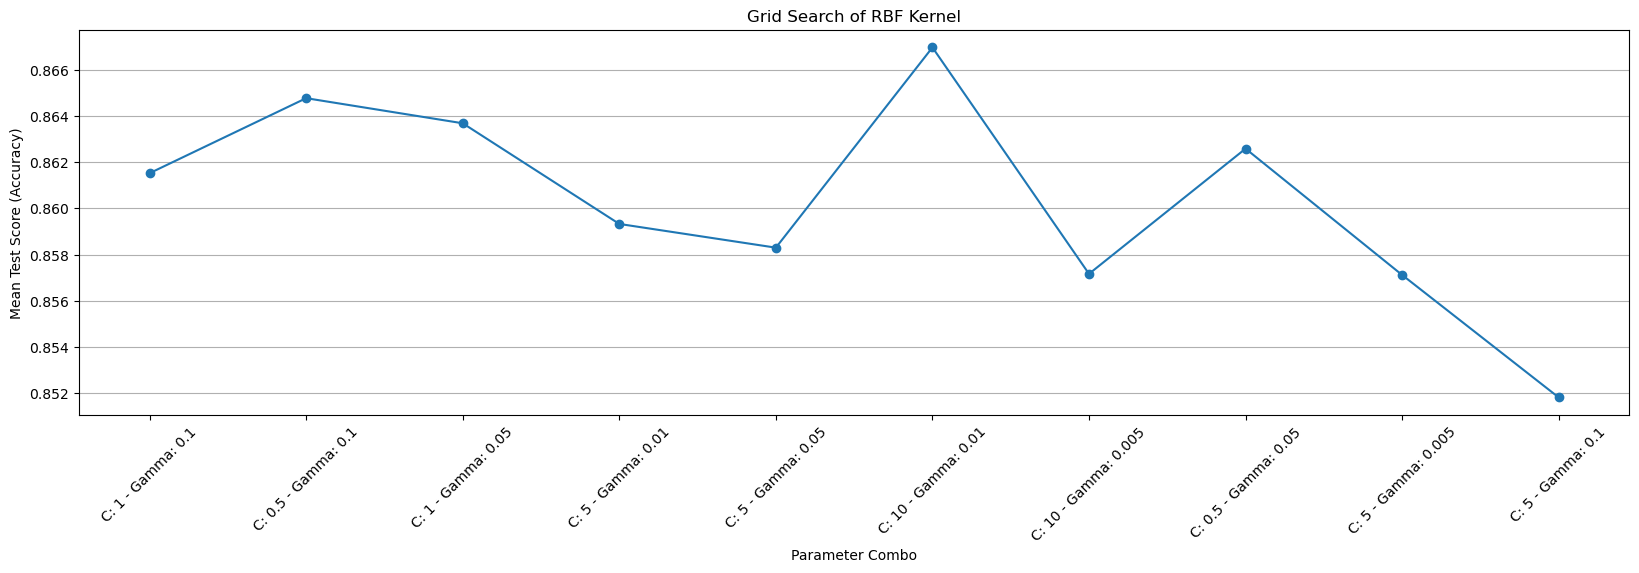

In [45]:
indices = np.argpartition(rbf_grid_search.cv_results_['rank_test_score'], 10)[:10]
mean_accuracy_scores = rbf_grid_search.cv_results_['mean_test_score'][indices]
top_para = []
for i in indices:
    temp = rbf_grid_search.cv_results_['params'][i]
    para = "C: " + str(temp['svc__C']) + " - Gamma: " + str(temp['svc__gamma'])
    top_para.append(para)

plt.figure(figsize=(20, 5))
plt.plot(top_para, mean_accuracy_scores, '-o')
plt.xticks(rotation=45)
plt.xlabel('Parameter Combo')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Grid Search of RBF Kernel')
plt.grid(axis='y')
plt.show()

In our analysis, we found that the SVM model using the Radial Basis Function (RBF) kernel outperformed the Linear SVC model. Specifically, when we set the regularization parameter, C, to 10 and the kernel coefficient, gamma, to 0.01, the RBF kernel SVM achieved a mean accuracy score of 0.87. This score is marginally higher than the 0.85 mean accuracy score of the Linear SVM model. Therefore, in this scenario, the RBF kernel SVM appears to be the more effective model.
</br>
Next on our exploration list is another variant of SVM - the one that uses a polynomial kernel. Let’s dive in and see how it performs!

<h5 style="color:green; text-align:left">SVM using polynomial kernel</h5>

With SVM using polynomial kernel, we will need to find the optimal value of C, degree, gamma, and coef0.

In [46]:
param_grid = {'svc__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'svc__degree': [2, 3, 4, 5], 'svc__gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], 'svc__coef0':[0, 0.1, 0.5, 1, 3, 5, 10]}
pipe = Pipeline(steps=[('svc', svm.SVC(kernel='poly', random_state=71))])
kf = KFold(n_splits=10)
poly_grid_search = GridSearchCV(pipe, param_grid, cv=kf, scoring='accuracy')
poly_grid_search.fit(scaled_X, y)

print(f"The best parameter combo is {poly_grid_search.best_params_} and its test mean score is {max(poly_grid_search.cv_results_['mean_test_score'])}")

The best parameter combo is {'svc__C': 0.05, 'svc__coef0': 5, 'svc__degree': 3, 'svc__gamma': 0.05} and its test mean score is 0.86589823220258


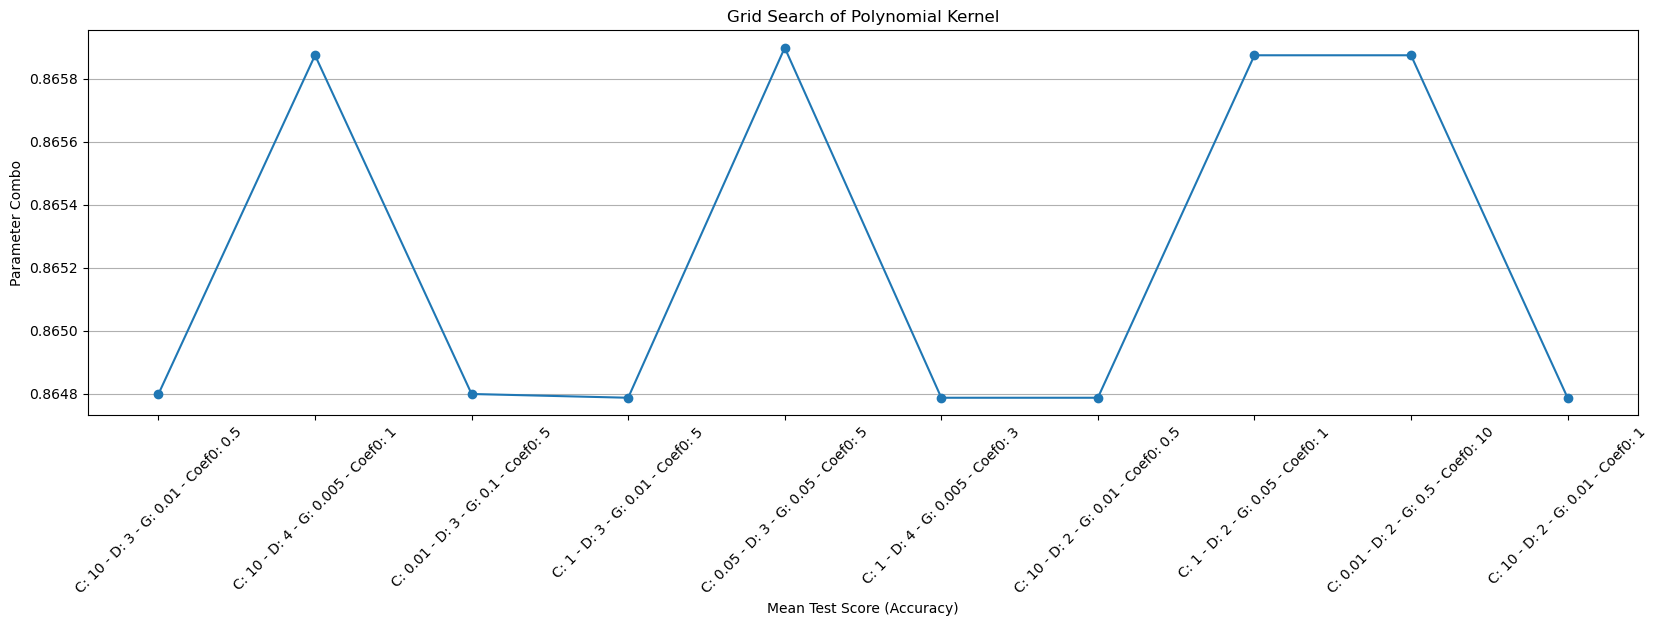

In [47]:
indices = np.argpartition(poly_grid_search.cv_results_['rank_test_score'], 10)[:10]
mean_accuracy_scores = poly_grid_search.cv_results_['mean_test_score'][indices]
top_para = []
for i in indices:
    temp = poly_grid_search.cv_results_['params'][i]
    para = "C: " + str(temp['svc__C']) + " - D: " + str(temp['svc__degree']) + " - G: " + str(temp['svc__gamma']) + " - Coef0: " + str(temp['svc__coef0'])
    top_para.append(para)

plt.figure(figsize=(20, 5))
plt.plot(top_para, mean_accuracy_scores, '-o')
plt.xticks(rotation=45)
plt.xlabel('Mean Test Score (Accuracy)')
plt.ylabel('Parameter Combo')
plt.title('Grid Search of Polynomial Kernel')
plt.grid(axis='y')
plt.show()

The mean accuracy score of the SVM using a polynomial kernel is 0.87, achieved with the parameter combination of C=0.05, degree=3, gamma=0.05, and coef0=5. This performance is approximately equivalent to that of the SVM using an RBF kernel. However, the computation time for the SVM with a polynomial kernel is longer. Therefore, we will opt for the SVM using an RBF kernel. Next, we will perform feature ranking and select important features, as the reduced model may help boost the accuracy of predictions

<h5 style="color:green; text-align:left">Feature Ranking</h5>

The size of this dataset is medium (not too big or too small). Additionally, it consists of a mix of numeric and categorical variables. Furthermore, it is a binary classification problem. Therefore, we will use Recursive Feature Elimination (RFE) with a Random Forest model to rank feature importance.

In [48]:
optimal_params = rbf_grid_search.best_params_
optimal_params

{'svc__C': 10, 'svc__gamma': 0.01}

In [49]:
optimal_C = optimal_params['svc__C']
optimal_gamma = optimal_params['svc__gamma']

In [50]:
rfe_model = RandomForestClassifier(n_estimators=100, random_state=74)
svm_rfe = RFE(estimator=rfe_model, n_features_to_select=1)
rbf_svm = svm.SVC(kernel='rbf', C=optimal_C, gamma=optimal_gamma)
pipe = Pipeline([
    ('feature_ranking', svm_rfe),
    ('classification', rbf_svm)
])

pipe.fit(scaled_X, y)
rfe = pipe.named_steps['feature_ranking']

feature_ranking = rfe.ranking_
feature_ranking

array([ 5,  7,  1, 12,  2,  4,  9,  8, 10, 11, 14, 13, 15,  6,  3])

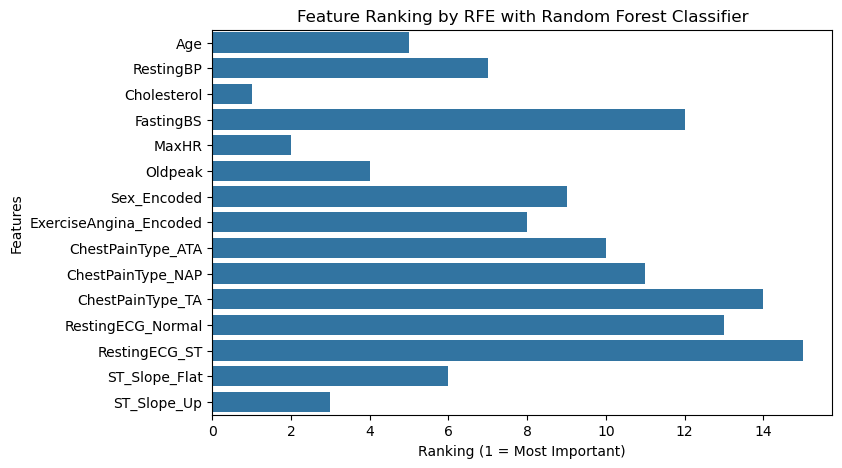

In [51]:
feature_names = X.columns

ranking_df = pd.DataFrame({
    'features': feature_names,
    'ranking': feature_ranking})

plt.figure(figsize=(8, 5))
sns.barplot(x='ranking', y='features', data=ranking_df)
plt.title('Feature Ranking by RFE with Random Forest Classifier')
plt.xlabel('Ranking (1 = Most Important)')
plt.ylabel('Features')
plt.show()

Based on the result above, `Cholesterol` is the most important feature, followed by `MaxHR` and `ST_Slope_Up`. The next step is to determine the number of features we need to retain for the reduced model. We can evaluate different numbers of features and use cross-validation to see how the model's performance changes.

In [52]:
n_features_range = range(1, X.shape[1] + 1) 

results = {}
for n in n_features_range:
    svm_rfe = RFE(estimator=rfe_model, n_features_to_select=n)
    pipe = Pipeline([
        ('feature_ranking', svm_rfe),
        ('classification', rbf_svm)
    ])
    
    scores = cross_val_score(pipe, scaled_X, y, cv=10)
    results[n] = scores.mean()

optimal_n_features = max(results, key=results.get)
print("Optimal number of features:", optimal_n_features)

Optimal number of features: 13


Since the optimal number of features is 13, we will eliminate the two least important features in the dataset, which are `RestingECG_ST` and `ChestPainType_TA`.

<h3 style="color:orange; align-text:left">Support Vector Machines (SVMs) - Reduced Model</h3>

In [53]:
features_to_drop = ['RestingECG_ST', 'ChestPainType_TA']
reduced_X = X.drop(columns=features_to_drop)
reduced_X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_Encoded,ExerciseAngina_Encoded,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,1,0,1,0,1,0,1
1,49,160,180,0,156,1.0,0,0,0,1,1,1,0
2,37,130,283,0,98,0.0,1,0,1,0,0,0,1
3,48,138,214,0,108,1.5,0,1,0,0,1,1,0
4,54,150,195,0,122,0.0,1,0,0,1,1,0,1


Since we dropped the two least important features, we will need to standardize the new dataset reduced_X.

In [54]:
scaler = StandardScaler()
scaled_reduced_X = scaler.fit_transform(reduced_X)

In [55]:
final_pipeline = Pipeline([
    ('svm', svm.SVC(kernel='rbf', C=optimal_C, gamma=optimal_gamma))
])

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(final_pipeline, scaled_reduced_X, y, cv=kfold, scoring='accuracy')
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy Score:", average_accuracy)

Average Accuracy Score: 0.8747252747252748


With the reduced model above, the average accuracy score is around 87%, which is approximately the same as that of the full model. We do not see a significant improvement here. Therefore, we will try Gradient Boosting and Particle Swarm Optimization next.

<h2 style="color:purple; text-align:left;">Predictive Model: Gradient Boosting with Particle Swarm Optimization</h2>

<h3 style="color:orange; align-text:left">Gradient Boosting</h3>

Gradient boosting, a machine learning ensemble method applicable to regression and classification tasks, operates by sequentially constructing a series of weak learners, typically decision trees. Each subsequent learner aims to rectify the errors of its predecessors. The fundamental principle of gradient boosting lies in amalgamating numerous weak models to forge a potent model capable of delivering precise predictions.

When optimizing a function using techniques like Particle Swarm Optimization (PSO), it’s common to minimize an objective function. In many cases, particularly with machine learning models, we might want to maximize a metric (such as accuracy or F1 score). However, most optimization algorithms, including PSO, are designed to minimize functions rather than maximize them. Hence, we negate the scores in the objective function.

Using Gradient Boosting with Particle Swarm Optimization (PSO) and cross-validation allows us to optimize the model's hyperparameters while ensuring performance validation on unseen data.

In [56]:
def objective_fn(params):
    n_estimators = int(params[0])
    learning_rate = params[1]
    max_depth = int(params[2])
    
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth
    )
    
    scores = cross_val_score(model, scaled_X, y, cv=10)
    return -scores.mean()  # we want to minimize the negative accuracy

lb = [50, 0.01, 1]  # Lower bounds: n_estimators, learning_rate, max_depth
ub = [200, 0.2, 10]  # Upper bounds

best_params, best_score = pso(objective_fn, lb, ub, swarmsize=30, maxiter=100)

print("Best Parameters:", best_params)
print("Best Cross-Validated Score:", -best_score)

Stopping search: maximum iterations reached --> 100
Best Parameters: [110.75835442   0.11658534   3.41811319]
Best Cross-Validated Score: 0.864787386526517


By using Gradient Boosting with PSO, the accuracy is approximately 86%, which is slightly less than that of the SVM model. So far, we haven't succeeded in building a model that surpasses 87% accuracy for the Heart Disease dataset. Next, we will attempt to build a Neural Network model.

<h2 style="color:purple; text-align:left;">Predictive Model: Neural Networks</h2>

Now we will use simple neural networks to seek better performance from our model.

In [57]:
X_tensor = torch.FloatTensor(scaled_X)
y_tensor = torch.FloatTensor(y.values).view(-1, 1)

In [58]:
kf = KFold(n_splits=10, shuffle=True, random_state=71)

In [59]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [60]:
accuracies = []

for train_index, test_index in kf.split(X_tensor):
    X_train, X_test = X_tensor[train_index], X_tensor[test_index]
    y_train, y_test = y_tensor[train_index], y_tensor[test_index]

    model = SimpleNN(input_size=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        predicted = (test_outputs > 0.5).float()  # Convert probabilities to binary
        accuracy = accuracy_score(y_test, predicted)
        accuracies.append(accuracy)

print(f'Average accuracy across 10 folds: {np.mean(accuracies):.2f}')

Average accuracy across 10 folds: 0.86


As the average accuracy across 10 folds for the simple neural network is 86%, we will try to improve our model by adding early stopping after 5 epochs of no improvement. We will also add a dropout layer and a sigmoid activation function for binary classification in our model.

In [63]:
import torch.nn.functional as F

class ImprovedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)  # Dropout layer
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [66]:
n_epochs = 100
learning_rate = 0.001

accuracies = []
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    
    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]
    
    model = ImprovedNN(input_size=X.shape[1])
    criterion = nn.BCELoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_loss = float('inf')
    patience = 5  # This is where we stop after 5 epochs of no improvement
    trigger_times = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        outputs = outputs.view(-1)  # Reshape to 1D for loss calculation
        loss = criterion(outputs, y_train.view(-1))  # Ensure y_train is also 1D
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).view(-1)
            val_loss = criterion(val_outputs, y_val.view(-1))
        
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print("Early stopping")
            break
    
    with torch.no_grad():
        val_predictions = (model(X_val).view(-1) > 0.5).float()
        accuracy = accuracy_score(y_val.numpy(), val_predictions.numpy())
        accuracies.append(accuracy)
        print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')

print(f'\nAverage accuracy across 10 folds: {np.mean(accuracies):.2f}')

Early stopping
Fold 1 Accuracy: 0.8478
Early stopping
Fold 2 Accuracy: 0.7500
Early stopping
Fold 3 Accuracy: 0.8804
Early stopping
Fold 4 Accuracy: 0.8587
Early stopping
Fold 5 Accuracy: 0.9022
Early stopping
Fold 6 Accuracy: 0.8913
Early stopping
Fold 7 Accuracy: 0.8696
Early stopping
Fold 8 Accuracy: 0.7717
Early stopping
Fold 9 Accuracy: 0.8571
Early stopping
Fold 10 Accuracy: 0.9011

Average accuracy across 10 folds: 0.85


Although we improved the neural network, the average accuracy across 10 folds is only 85%, which is slightly lower than that of the simple neural network (86%).

<h2 style="color:purple; text-align:left;">Summary</h2>

To summarize what we did in this project:
- To prevent data leakage, we used Pipeline.
- To have training and testing set, we used 10-fold cross validation.
- For hyperparameter tuning, we used GridSearchCV and for the measurement of mean accuracy score, we used cross_val_score. Additionally, we also apply Particle Swarms Optimization.
- By using three different models (SVM, Gradient Boosting, and Neural Networks), the highest accuracy of all models' performance is 87%.
- The accuracy scores are as follows:
  - SVM - full model: 0.87
  - SVM with RFE - reduced model: 0.87
  - Gradient Boosting with PSO: 0.86
  - Neural Networks - Simple NN: 0.86
  - Neural Networks - Improved NN: 0.85